In [1]:
# ============================================
# COMPLETE ECONOMIC FORECASTING IMPLEMENTATION
# Step-by-step: Data Processing → Modeling → Evaluation
# ============================================

In [7]:
import tensorflow as tf

In [4]:
pip install scikit-learn keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 5.5 MB/s  0:00:01 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 11.8 MB/s  0:00:012.0 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [8]:
import sklearn
import keras

In [ ]:
#pip install pandas numpy matplotlib seaborn plotly tensorflow scikit-learn

In [3]:
pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 9.5 MB/s  0:00:00m 9.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.8 MB/s  0:00:002.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [seaborn]━━━ 6/7 [seaborn]atplotlib]
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 9.0 MB/s  0:00:01m 8.9 MB/s eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]━━━━ 1/2 [plotly]
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.subplots import make_subplots

In [3]:
pip install statsmodels

  Using cached statsmodels-0.14.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.5 kB)
Using cached statsmodels-0.14.5-cp310-cp310-macosx_11_0_arm64.whl (9.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] 1/2 [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Statistical models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 3.5 MB/s  0:00:03m 3.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.6 MB/s  0:00:00m 3.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [prophet]━━━ 4/5 [prophet]]
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Prophet
from prophet import Prophet

/opt/miniconda3/envs/tf-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [13]:
# LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")



✅ All libraries imported successfully!


In [46]:
# ============================================
# STEP 1: HANDLE MISSING VALUES
# ============================================

In [14]:
def handle_missing_values(df, method='forward_fill'):
    """
    Handle missing values in time series data
    
    Parameters:
    -----------
    df : pd.DataFrame
        Time series data with datetime index
    method : str
        'forward_fill', 'interpolate', or 'hybrid'
    
    Returns:
    --------
    pd.DataFrame
        Data with missing values handled
    """
    print("\n" + "="*60)
    print("STEP 1: HANDLING MISSING VALUES")
    print("="*60)
    
    # Check for missing values
    missing_before = df.isnull().sum()
    missing_pct = (missing_before / len(df)) * 100
    
    print("\n📊 Missing Values Before:")
    for col in df.columns:
        if missing_before[col] > 0:
            print(f"   {col}: {missing_before[col]} ({missing_pct[col]:.2f}%)")
    
    if missing_before.sum() == 0:
        print("   ✅ No missing values found!")
        return df
    
    # Apply selected method
    df_clean = df.copy()
    
   

In [15]:
def clean_missing_values(df, method="interpolate"):
    df_clean = df.copy()

    if method == "interpolate":
        print("\n🔧 Applying linear interpolation...")
        df_clean = df_clean.interpolate(method="linear", limit_direction="both")

    elif method == "hybrid":
        print("\n🔧 Applying hybrid approach...")
        df_clean = (
            df_clean.interpolate(method="linear", limit=5)
                     .fillna(method="ffill")
                     .fillna(method="bfill")
        )

    return df_clean
    

In [9]:
#skip def clean_missing_values(df, method="interpolate"):
    df_clean = df.copy()

    if method == "interpolate":
        print("\n🔧 Applying linear interpolation...")
        df_clean = df_clean.interpolate(method="linear", limit_direction="both")

    elif method == "hybrid":
        print("\n🔧 Applying hybrid approach...")
        df_clean = (
            df_clean.interpolate(method="linear", limit=5)
                     .fillna(method="ffill")
                     .fillna(method="bfill")
        )

    return df_clean
    #skip    if method == 'forward_fill':
    print("\n🔧 Applying forward fill...")
    df_clean = df_clean.fillna(method='ffill')
        # Backward fill any remaining NaN at start
    df_clean = df_clean.fillna(method='backfill')
        
    elif method == 'interpolate':
        print("\n🔧 Applying linear interpolation...")
        df_clean = df_clean.interpolate(method='linear', limit_direction='both')
        
    elif method == 'hybrid':
        print("\n🔧 Applying hybrid approach...")
        # Interpolate for small gaps (<5 values)
        df_clean = df_clean.interpolate(method='linear', limit=5)
        # Forward fill for larger gaps
        df_clean = df_clean.fillna(method='ffill')
        df_clean = df_clean.fillna(method='bfill')
    
    # Verify
    missing_after = df_clean.isnull().sum()
    print("\n📊 Missing Values After:")
    if missing_after.sum() == 0:
        print("   ✅ All missing values handled!")
    else:
        print(f"   ⚠️ Remaining missing values: {missing_after.sum()}")
    
    return df_clean




SyntaxError: invalid syntax (568258958.py, line 23)

In [ ]:
#skip    if method == 'forward_fill':
        print("\n🔧 Applying forward fill...")
        df_clean = df_clean.fillna(method='ffill')
        # Backward fill any remaining NaN at start
        df_clean = df_clean.fillna(method='backfill')
        
    elif method == 'interpolate':
        print("\n🔧 Applying linear interpolation...")
        df_clean = df_clean.interpolate(method='linear', limit_direction='both')
        
    elif method == 'hybrid':
        print("\n🔧 Applying hybrid approach...")
        # Interpolate for small gaps (<5 values)
        df_clean = df_clean.interpolate(method='linear', limit=5)
        # Forward fill for larger gaps
        df_clean = df_clean.fillna(method='ffill')
        df_clean = df_clean.fillna(method='bfill')
    
    # Verify
    missing_after = df_clean.isnull().sum()
    print("\n📊 Missing Values After:")
    if missing_after.sum() == 0:
        print("   ✅ All missing values handled!")
    else:
        print(f"   ⚠️ Remaining missing values: {missing_after.sum()}")
    
    return df_clean


In [14]:
# ============================================
# STEP 2: TEST STATIONARITY & APPLY DIFFERENCING
# ============================================


In [16]:

def test_stationarity(series, name='Series'):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    """
    result = adfuller(series.dropna())
    
    print(f"\n📊 ADF Test Results for {name}:")
    print(f"   ADF Statistic: {result[0]:.6f}")
    print(f"   p-value: {result[1]:.6f}")
    print(f"   Critical Values:")
    for key, value in result[4].items():
        print(f"      {key}: {value:.3f}")
    
    if result[1] < 0.05:
        print(f"   ✅ STATIONARY (p < 0.05)")
        return True
    else:
        print(f"   ❌ NON-STATIONARY (p >= 0.05)")
        return False


In [17]:
def make_stationary(df, columns=None):
    """
    Apply differencing to non-stationary series
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original time series data
    columns : list
        Columns to check and difference (None = all)
    
    Returns:
    --------
    tuple : (df_stationary, difference_orders)
        Stationary data and dict of difference orders applied
    """
    print("\n" + "="*60)
    print("STEP 2: TESTING STATIONARITY & DIFFERENCING")
    print("="*60)
    
    if columns is None:
        columns = df.columns
    
    df_stationary = df.copy()
    difference_orders = {}
    
    for col in columns:
        print(f"\n🔬 Testing: {col}")
        
        series = df[col].dropna()
        is_stationary = test_stationarity(series, col)
        
        if is_stationary:
            difference_orders[col] = 0
            continue
        
        # Try first difference
        print(f"\n   Applying first difference...")
        diff1 = series.diff().dropna()
        is_stationary_diff1 = test_stationarity(diff1, f"{col} (1st diff)")
        
        if is_stationary_diff1:
            df_stationary[col] = df[col].diff()
            difference_orders[col] = 1
        else:
            # Try second difference
            print(f"\n   Applying second difference...")
            diff2 = diff1.diff().dropna()
            is_stationary_diff2 = test_stationarity(diff2, f"{col} (2nd diff)")
            
            if is_stationary_diff2:
                df_stationary[col] = df[col].diff().diff()
                difference_orders[col] = 2
            else:
                print(f"   ⚠️ Still non-stationary after 2nd difference")
                df_stationary[col] = df[col].diff().diff()
                difference_orders[col] = 2
    
    # Remove NaN created by differencing
    df_stationary = df_stationary.dropna()
    
    print("\n📊 Summary:")
    for col, order in difference_orders.items():
        print(f"   {col}: {'No differencing' if order == 0 else f'{order} difference(s)'}")
    
    return df_stationary, difference_orders


In [51]:
# ============================================
# STEP 3: FEATURE ENGINEERING
# ============================================


In [18]:
def create_features(df, target_col, lags=[1, 3, 6, 12], rolling_windows=[3, 6, 12]):
    """
    Create lag features and rolling statistics
    
    Parameters:
    -----------
    df : pd.DataFrame
        Time series data
    target_col : str
        Target variable column name
    lags : list
        Lag periods to create
    rolling_windows : list
        Rolling window sizes for statistics
    
    Returns:
    --------
    pd.DataFrame
        Data with engineered features
    """
    print("\n" + "="*60)
    print("STEP 3: FEATURE ENGINEERING")
    print("="*60)
    
    df_features = df.copy()
    
    # 1. LAG FEATURES
    print(f"\n🔧 Creating lag features for {target_col}...")
    for lag in lags:
        df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)
        print(f"   ✓ Created lag_{lag}")
    
    # 2. ROLLING STATISTICS
    print(f"\n🔧 Creating rolling statistics...")
    for window in rolling_windows:
        # Rolling mean
        df_features[f'{target_col}_rolling_mean_{window}'] = \
            df_features[target_col].rolling(window=window).mean()
        
        # Rolling std
        df_features[f'{target_col}_rolling_std_{window}'] = \
            df_features[target_col].rolling(window=window).std()
        
        # Rolling min/max
        df_features[f'{target_col}_rolling_min_{window}'] = \
            df_features[target_col].rolling(window=window).min()
        
        df_features[f'{target_col}_rolling_max_{window}'] = \
            df_features[target_col].rolling(window=window).max()
        
        print(f"   ✓ Created rolling features (window={window})")
    
    # 3. RATE OF CHANGE
    print(f"\n🔧 Creating rate of change features...")
    df_features[f'{target_col}_pct_change_1'] = df_features[target_col].pct_change(1)
    df_features[f'{target_col}_pct_change_12'] = df_features[target_col].pct_change(12)
    print(f"   ✓ Created percent change features")
    
    # 4. MOMENTUM INDICATORS
    print(f"\n🔧 Creating momentum indicators...")
    df_features[f'{target_col}_momentum'] = \
        df_features[target_col] - df_features[target_col].shift(12)
    print(f"   ✓ Created momentum features")
    
    # 5. DATE/TIME FEATURES
    print(f"\n🔧 Creating temporal features...")
    df_features['month'] = df_features.index.month
    df_features['quarter'] = df_features.index.quarter
    df_features['year'] = df_features.index.year
    print(f"   ✓ Created temporal features")
    
    # Remove NaN created by feature engineering
    initial_rows = len(df_features)
    df_features = df_features.dropna()
    final_rows = len(df_features)
    
    print(f"\n📊 Feature Engineering Summary:")
    print(f"   Original features: {len(df.columns)}")
    print(f"   Total features: {len(df_features.columns)}")
    print(f"   New features: {len(df_features.columns) - len(df.columns)}")
    print(f"   Rows after cleaning: {final_rows} (removed {initial_rows - final_rows})")
    
    return df_features


In [19]:

# ============================================
# STEP 4: BUILD FORECASTING MODELS
# ============================================



In [19]:
# MODEL 1: ARIMA
# ============================================

def build_arima_model(train_data, test_data, order=(1,1,1)):
    """
    Build and evaluate ARIMA model
    
    Parameters:
    -----------
    train_data : pd.Series
        Training data
    test_data : pd.Series
        Testing data
    order : tuple
        ARIMA order (p, d, q)
    
    Returns:
    --------
    dict : Model results and predictions
    """
    print("\n" + "="*60)
    print("MODEL 1: ARIMA")
    print("="*60)
    
    print(f"\n🔧 Training ARIMA{order}...")
    
    # Fit model
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    
    print(f"✅ Model trained successfully!")
    print(f"\nModel Summary:")
    print(model_fit.summary())
    
    # Make predictions
    print(f"\n📊 Generating predictions...")
    predictions = model_fit.forecast(steps=len(test_data))
    
    # Calculate metrics
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, predictions)
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100
    r2 = r2_score(test_data, predictions)
    
    print(f"\n📈 Performance Metrics:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R² Score: {r2:.4f}")
    
    return {
        'model': model_fit,
        'predictions': predictions,
        'metrics': {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }
    }

# MODEL 2: PROPHET


In [20]:
# ============================================

def build_prophet_model(train_data, test_data, seasonality_mode='multiplicative'):
    """
    Build and evaluate Prophet model
    
    Parameters:
    -----------
    train_data : pd.Series
        Training data with datetime index
    test_data : pd.Series
        Testing data with datetime index
    seasonality_mode : str
        'additive' or 'multiplicative'
    
    Returns:
    --------
    dict : Model results and predictions
    """
    print("\n" + "="*60)
    print("MODEL 2: PROPHET")
    print("="*60)
    
    print(f"\n🔧 Training Prophet model (seasonality: {seasonality_mode})...")
    
    # Prepare data for Prophet
    train_df = pd.DataFrame({
        'ds': train_data.index,
        'y': train_data.values
    })
    
    # Initialize and fit model
    model = Prophet(
        seasonality_mode=seasonality_mode,
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    
    model.fit(train_df)
    print(f"✅ Model trained successfully!")
    
    # Create future dataframe
    future = pd.DataFrame({'ds': test_data.index})
    
    # Make predictions
    print(f"\n📊 Generating predictions...")
    forecast = model.predict(future)
    predictions = forecast['yhat'].values
    
    # Calculate metrics
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, predictions)
    mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100
    r2 = r2_score(test_data, predictions)
    
    print(f"\n📈 Performance Metrics:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R² Score: {r2:.4f}")
    
    return {
        'model': model,
        'forecast': forecast,
        'predictions': predictions,
        'metrics': {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }
    }

# MODEL 3: LSTM


In [21]:
# ============================================

def prepare_lstm_data(data, look_back=12):
    """
    Prepare data for LSTM model
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)


In [22]:
def build_lstm_model(train_data, test_data, look_back=12, epochs=50, batch_size=32):
    """
    Build and evaluate LSTM model
    
    Parameters:
    -----------
    train_data : pd.Series
        Training data
    test_data : pd.Series
        Testing data
    look_back : int
        Number of previous time steps to use
    epochs : int
        Training epochs
    batch_size : int
        Batch size for training
    
    Returns:
    --------
    dict : Model results and predictions
    """
    print("\n" + "="*60)
    print("MODEL 3: LSTM")
    print("="*60)
    
    print(f"\n🔧 Preparing data for LSTM (look_back={look_back})...")
    
    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.values.reshape(-1, 1))
    
    # Prepare sequences
    X_train, y_train = prepare_lstm_data(train_scaled.flatten(), look_back)
    X_test, y_test = prepare_lstm_data(test_scaled.flatten(), look_back)
    
    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    print(f"   Train shape: {X_train.shape}")
    print(f"   Test shape: {X_test.shape}")
    
    # Build LSTM model
    print(f"\n🔧 Building LSTM architecture...")
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    print(f"\nModel Architecture:")
    model.summary()
    
    # Train model
    print(f"\n🔧 Training LSTM model...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=0
    )
    
    print(f"✅ Model trained successfully!")
    print(f"   Final training loss: {history.history['loss'][-1]:.6f}")
    print(f"   Final validation loss: {history.history['val_loss'][-1]:.6f}")
    
    # Make predictions
    print(f"\n📊 Generating predictions...")
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler.inverse_transform(predictions_scaled)
    
    # Get actual test values (accounting for look_back)
    test_actual = test_data.values[look_back:]
    
    # Calculate metrics
    mse = mean_squared_error(test_actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_actual, predictions)
    mape = np.mean(np.abs((test_actual - predictions.flatten()) / test_actual)) * 100
    r2 = r2_score(test_actual, predictions)
    
    print(f"\n📈 Performance Metrics:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   R² Score: {r2:.4f}")
    
    return {
        'model': model,
        'scaler': scaler,
        'predictions': predictions.flatten(),
        'history': history,
        'look_back': look_back,
        'test_actual': test_actual,
        'metrics': {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }
    }



In [21]:
# ============================================
# STEP 5: MODEL EVALUATION & COMPARISON
# ============================================


In [23]:
def compare_models(models_dict, test_data, model_names=['ARIMA', 'Prophet', 'LSTM']):
    """
    Compare performance of multiple models
    
    Parameters:
    -----------
    models_results : dict
        Dictionary of model results
    test_data : pd.Series
        Test data for comparison
    model_names : list
        Names of models to compare
    
    Returns:
    --------
    pd.DataFrame : Comparison table
    """
    print("\n" + "="*60)
    print("STEP 5: MODEL COMPARISON & EVALUATION")
    print("="*60)
    
    comparison_data = []
    
    for name in model_names:
        if name in models_dict:
            metrics = models_dict[name]['metrics']
            comparison_data.append({
                'Model': name,
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'MAPE': f"{metrics['MAPE']:.2f}%",
                'R² Score': metrics['R2']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 Model Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Find best model
    best_model_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
    best_model_r2 = comparison_df.loc[comparison_df['R² Score'].idxmax(), 'Model']
    
    print(f"\n🏆 Best Models:")
    print(f"   Lowest RMSE: {best_model_rmse}")
    print(f"   Highest R²: {best_model_r2}")
    
    return comparison_df


In [35]:
def plot_predictions(test_data, models_dict, model_names=['ARIMA', 'Prophet', 'LSTM']):
    """
    Plot actual vs predicted values for all models
    """
    print("\n📊 Generating comparison plots...")
    
    fig = go.Figure()
    
    # Actual values
    fig.add_trace(go.Scatter(
        x=test_data.index[:len(test_data)],
        y=test_data.values,
        mode='lines',
        name='Actual',
        line=dict(color='black', width=3)
    ))
    
    # Model predictions
    colors = ['blue', 'red', 'green']
    for idx, name in enumerate(model_names):
        if name in models_dict:
            predictions = models_dict[name]['predictions']
            
            # Align predictions with test data index
            if name == 'LSTM':
                # LSTM predictions start after look_back period
                look_back = models_dict[name]['look_back']
                x_vals = test_data.index[look_back:look_back+len(predictions)]
            else:
                x_vals = test_data.index[:len(predictions)]
            
            fig.add_trace(go.Scatter(
                x=x_vals,
                y=predictions,
                mode='lines',
                name=f'{name} (MAPE: {models_dict[name]["metrics"]["MAPE"]:.2f}%)',
                line=dict(color=colors[idx], width=2, dash='dash')
            ))
    
    fig.update_layout(
        title='Model Predictions Comparison',
        xaxis_title='Date',
        yaxis_title='Value',
        hovermode='x unified',
        height=600,
        template='plotly_white',
        legend=dict(x=0.01, y=0.99)
    )

    # Save to HTML
    fig.write_html("plot_predictions.html", include_plotlyjs="cdn")

    fig.show()
    
    return fig
    
    print("✅ Comparison plot generated!")


In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_residuals(test_data, models_dict, model_names=['ARIMA', 'Prophet', 'LSTM']):
    """
    Plot residuals for all models using Plotly
    """
    print("\n📊 Generating residual plots...")

    # Create subplot grid: one row per model, 2 columns (time series + histogram)
    fig = make_subplots(
        rows=len(model_names), cols=2,
        subplot_titles=[f"{name} - Residuals Over Time" for name in model_names] +
                       [f"{name} - Residual Distribution" for name in model_names],
        horizontal_spacing=0.15,
        vertical_spacing=0.1
    )

    for idx, name in enumerate(model_names, start=1):
        if name in models_dict:
            predictions = models_dict[name]['predictions']

            # Align actuals
            if name == 'LSTM':
                look_back = models_dict[name]['look_back']
                actual = test_data.values[look_back:look_back+len(predictions)]
                x_vals = test_data.index[look_back:look_back+len(predictions)]
            else:
                actual = test_data.values[:len(predictions)]
                x_vals = test_data.index[:len(predictions)]

            residuals = actual - predictions

            # Residuals over time (line plot)
            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=residuals,
                    mode='lines',
                    line=dict(color='blue', width=1.5),
                    name=f"{name} Residuals"
                ),
                row=idx, col=1
            )
            # Add horizontal zero line
            fig.add_hline(y=0, line=dict(color='red', dash='dash', width=2),
                          row=idx, col=1)

            # Residual histogram
            fig.add_trace(
                go.Histogram(
                    x=residuals,
                    nbinsx=30,
                    marker=dict(color='steelblue', line=dict(color='black', width=1)),
                    opacity=0.7,
                    name=f"{name} Residuals Dist"
                ),
                row=idx, col=2
            )
            # Add vertical zero line
            fig.add_vline(x=0, line=dict(color='red', dash='dash', width=2),
                          row=idx, col=2)

    # Layout
    fig.update_layout(
        height=400*len(model_names),
        width=1000,
        title_text="Residual Plots for All Models",
        template="plotly_white",
        showlegend=False
    )

    # Save to HTML
    fig.write_html("plot_residuals.html", include_plotlyjs="cdn")

    # Show interactive plot
    fig.show()

    print("✅ Residual plots generated and saved to HTML!")
    return fig

In [25]:
#skip def plot_residuals(test_data, models_dict, model_names=['ARIMA', 'Prophet', 'LSTM']):
    """
    Plot residuals for all models
    """
    print("\n📊 Generating residual plots...")
    
    fig, axes = plt.subplots(len(model_names), 2, figsize=(14, 4*len(model_names)))
    
    for idx, name in enumerate(model_names):
        if name in models_dict:
            predictions = models_dict[name]['predictions']
            
            # Calculate residuals
            if name == 'LSTM':
                look_back = models_dict[name]['look_back']
                actual = test_data.values[look_back:look_back+len(predictions)]
            else:
                actual = test_data.values[:len(predictions)]
            
            residuals = actual - predictions
            
            # Residual plot
            axes[idx, 0].plot(residuals, linewidth=1.5, color='blue')
            axes[idx, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
            axes[idx, 0].set_title(f'{name} - Residuals Over Time')
            axes[idx, 0].set_xlabel('Time')
            axes[idx, 0].set_ylabel('Residual')
            axes[idx, 0].grid(True, alpha=0.3)
            
            # Residual histogram
            axes[idx, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
            axes[idx, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
            axes[idx, 1].set_title(f'{name} - Residual Distribution')
            axes[idx, 1].set_xlabel('Residual')
            axes[idx, 1].set_ylabel('Frequency')
            axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save to HTML
    fig.write_html("plot_residuals.html", include_plotlyjs="cdn")
    plt.show()

    return plt
    
    print("✅ Residual plots generated!")



In [118]:
# ============================================
# COMPLETE WORKFLOW FUNCTION
# ============================================


In [37]:
def complete_forecasting_workflow(data, target_col, test_size=0.2):
    """
    Run complete forecasting workflow from data processing to evaluation
    
    Parameters:
    -----------
    data : pd.DataFrame
        Time series data with datetime index
    target_col : str
        Target variable to forecast
    test_size : float
        Proportion of data for testing
    
    Returns:
    --------
    dict : All results including processed data and model predictions
    """
    print("\n" + "="*60)
    print("🚀 COMPLETE ECONOMIC FORECASTING WORKFLOW")
    print("="*60)
    print(f"\nTarget Variable: {target_col}")
    print(f"Data Shape: {data.shape}")
    print(f"Date Range: {data.index.min().date()} to {data.index.max().date()}")
    
    # Step 1: Handle missing values
    data_clean = handle_missing_values(data, method='hybrid')
    
    # Step 2: Test stationarity (keep original for modeling)
    target_series = data_clean[target_col]
    
    # Step 3: Feature engineering (optional - for future use)
    # data_features = create_features(data_clean, target_col)
    
    # Split data
    split_idx = int(len(target_series) * (1 - test_size))
    train_data = target_series[:split_idx]
    test_data = target_series[split_idx:]
    
    print(f"\n📊 Data Split:")
    print(f"   Training: {len(train_data)} samples ({train_data.index.min().date()} to {train_data.index.max().date()})")
    print(f"   Testing: {len(test_data)} samples ({test_data.index.min().date()} to {test_data.index.max().date()})")
    
    # Step 4: Build models
    models_results = {}
    
    # ARIMA
    try:
        models_results['ARIMA'] = build_arima_model(train_data, test_data, order=(2,1,2))
    except Exception as e:
        print(f"\n❌ ARIMA failed: {e}")
    
    # Prophet
    try:
        models_results['Prophet'] = build_prophet_model(train_data, test_data)
    except Exception as e:
        print(f"\n❌ Prophet failed: {e}")
    
    # LSTM
    try:
        models_results['LSTM'] = build_lstm_model(train_data, test_data, look_back=12, epochs=50)
    except Exception as e:
        print(f"\n❌ LSTM failed: {e}")
    
    # Step 5: Compare and evaluate
    comparison_df = compare_models(models_results, test_data)
    
    # Generate plots
    plot_predictions(test_data, models_results)
    plot_residuals(test_data, models_results)
    
    print("\n" + "="*60)
    print("✅ WORKFLOW COMPLETE!")
    print("="*60)
    
    return {
        'data_clean': data_clean,
        'train_data': train_data,
        'test_data': test_data,
        'models': models_results,
        'comparison': comparison_df
    }



In [3]:
# ============================================
# EXAMPLE USAGE
# ============================================


In [38]:
if __name__ == "__main__":
    print("\n" + "="*60)
    print("EXAMPLE: Running Complete Workflow")
    print("="*60)
    
    # Load your data (replace with your actual data)
    # Assuming you have 'economic_data' from previous setup
    
    # For demo, let's create sample data
    # In practice, use: economic_data = pd.read_csv('economic_indicators.csv', index_col=0, parse_dates=True)
    
    print("\n💡 To run this workflow with your data:")
    print("\n# Load your data")
    print("economic_data = pd.read_csv('economic_indicators.csv', index_col=0, parse_dates=True)")
    print("\n# Run complete workflow")
    print("results = complete_forecasting_workflow(")
    print("    data=economic_data,")
    print("    target_col='Unemployment Rate',  # or 'Consumer Price Index', etc.")
    print("    test_size=0.2")
    print(")")
    print("\n# Access results")
    print("comparison_table = results['comparison']")
    print("best_model = results['models']['Prophet']  # or 'ARIMA', 'LSTM'")
    
    print("\n✅ All functions defined and ready to use!")




EXAMPLE: Running Complete Workflow

💡 To run this workflow with your data:

# Load your data
economic_data = pd.read_csv('economic_indicators.csv', index_col=0, parse_dates=True)

# Run complete workflow
results = complete_forecasting_workflow(
    data=economic_data,
    target_col='Unemployment Rate',  # or 'Consumer Price Index', etc.
    test_size=0.2
)

# Access results
comparison_table = results['comparison']
best_model = results['models']['Prophet']  # or 'ARIMA', 'LSTM'

✅ All functions defined and ready to use!


In [39]:
#import pandas as pd
economic_data = pd.read_csv("/Users/jessicabean/Library/CloudStorage/OneDrive-Personal/porftfolio.github.io/projects/economic_indicators/data/raw/economic_indicators_clean.csv", index_col=0, parse_dates=True)
#economic_data = "df_clean"



🚀 COMPLETE ECONOMIC FORECASTING WORKFLOW

Target Variable: Consumer Price Index
Data Shape: (190, 8)
Date Range: 2010-01-01 to 2025-10-01

STEP 1: HANDLING MISSING VALUES

📊 Missing Values Before:
   ✅ No missing values found!

📊 Data Split:
   Training: 152 samples (2010-01-01 to 2022-08-01)
   Testing: 38 samples (2022-09-01 to 2025-10-01)

MODEL 1: ARIMA

🔧 Training ARIMA(2, 1, 2)...


06:27:32 - cmdstanpy - INFO - Chain [1] start processing


✅ Model trained successfully!

Model Summary:
                                SARIMAX Results                                 
Dep. Variable:     Consumer Price Index   No. Observations:                  152
Model:                   ARIMA(2, 1, 2)   Log Likelihood                -131.768
Date:                  Tue, 02 Dec 2025   AIC                            273.536
Time:                          06:27:32   BIC                            288.623
Sample:                      01-01-2010   HQIC                           279.665
                           - 08-01-2022                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8754      0.186      4.715      0.000       0.511       1.239
ar.L2          0.1138      0.179      0.637      0.524      -0.236   

06:27:32 - cmdstanpy - INFO - Chain [1] done processing


✅ Model trained successfully!

📊 Generating predictions...

📈 Performance Metrics:
   RMSE: 5.2299
   MAE: 4.3719
   MAPE: 1.39%
   R² Score: 0.5884

MODEL 3: LSTM

🔧 Preparing data for LSTM (look_back=12)...
   Train shape: (140, 12, 1)
   Test shape: (26, 12, 1)

🔧 Building LSTM architecture...

Model Architecture:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 12, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 

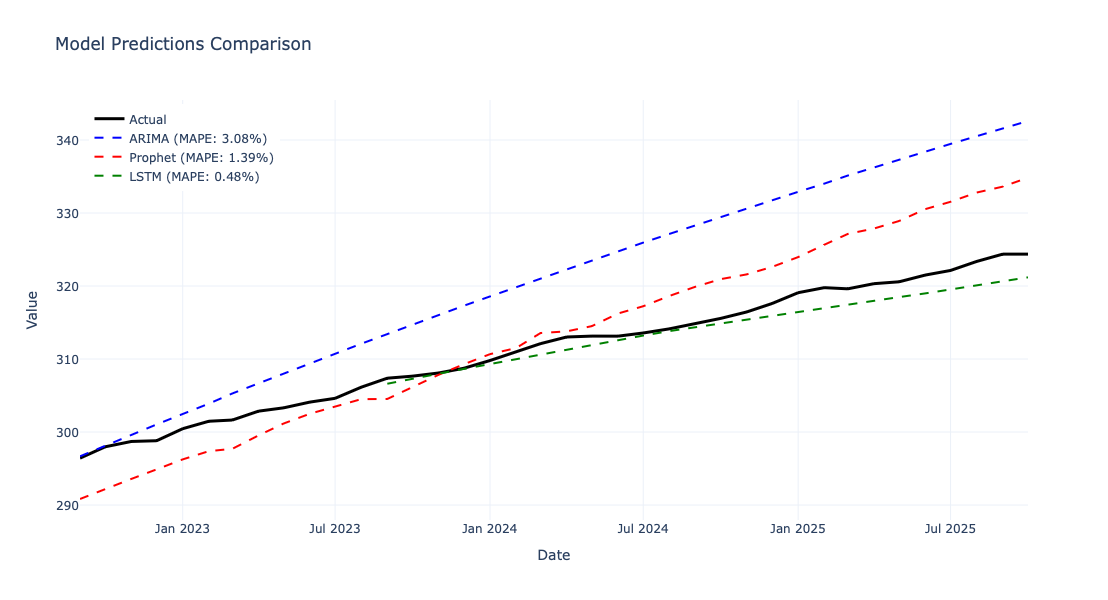


📊 Generating residual plots...


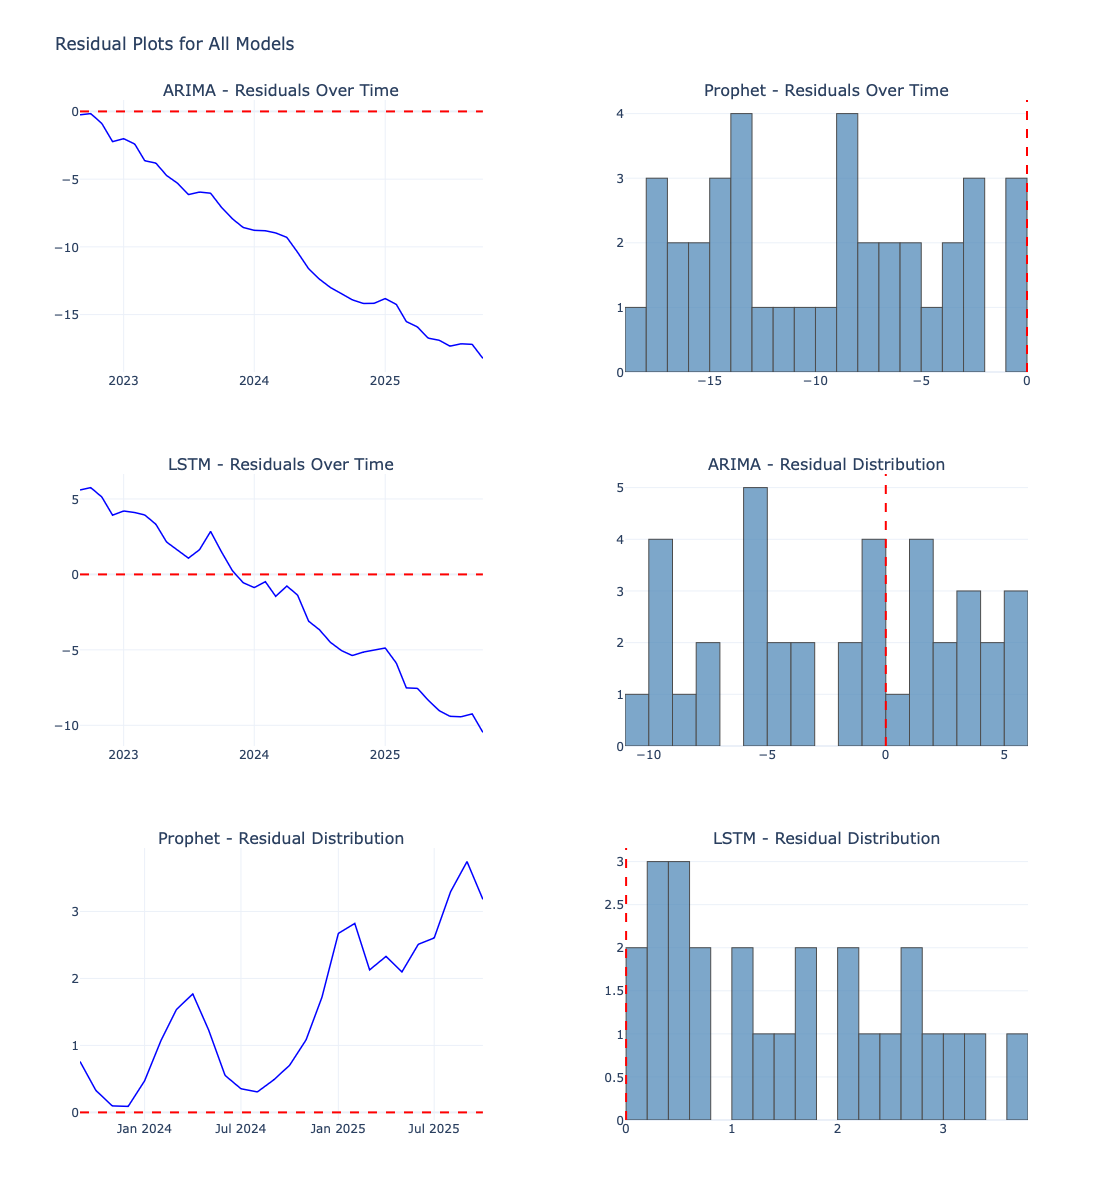

✅ Residual plots generated and saved to HTML!

✅ WORKFLOW COMPLETE!


In [54]:
results = complete_forecasting_workflow(
    data=economic_data,
    target_col='Consumer Price Index',  # or 'Consumer Price Index', etc.
    test_size=0.2
)


In [61]:
import json
import pickle
import pandas as pd

def export_forecasting_results(results, prefix="forecast_results"):
    """
    Export forecasting workflow results to JSON, Pickle, CSV, and Excel.
    Handles both nested and top-level metrics.
    """

    # --- 1. Save full results dict as JSON ---
    with open(f"{prefix}.json", "w") as f:
        json.dump(results, f, indent=4, default=str)  # default=str handles datetime

    # --- 2. Save full results dict as Pickle ---
    with open(f"{prefix}.pkl", "wb") as f:
        pickle.dump(results, f)

    # --- 3. Flatten metrics into a DataFrame ---
    metrics_rows = []
    for model, info in results.items():
        row = {"Model": model}
        for k, v in info.items():
            if isinstance(v, (int, float)):
                row[k] = v
            elif isinstance(v, dict):
                # Flatten nested dicts (e.g. metrics)
                for mk, mv in v.items():
                    row[mk] = mv
        metrics_rows.append(row)

    df_metrics = pd.DataFrame(metrics_rows)
    df_metrics.to_csv(f"{prefix}_metrics.csv", index=False)

    # --- 4. Save predictions to CSV ---
    preds_rows = []
    for model, info in results.items():
        if "predictions" in info:
            for i, val in enumerate(info["predictions"]):
                preds_rows.append({"Model": model, "Step": i, "Prediction": val})
    df_preds = pd.DataFrame(preds_rows)
    df_preds.to_csv(f"{prefix}_predictions.csv", index=False)

    print(f"✅ Results exported: {prefix}.json, {prefix}.pkl, {prefix}_metrics.csv,{prefix}_predictions.csv")

In [62]:
import pandas as pd

metrics = []
for model, info in results.items():
    row = {"Model": model}
    # Add any numeric/stat keys that exist
    for k, v in info.items():
        if isinstance(v, (int, float)):
            row[k] = v
        elif isinstance(v, dict):
            # If you do have a nested metrics dict, flatten it
            for mk, mv in v.items():
                row[mk] = mv
    metrics.append(row)

df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv("forecast_metrics.csv", index=False)

In [63]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_residuals(test_data, models_dict, model_names=['ARIMA', 'Prophet', 'LSTM']):
    """
    Plot residuals for all models using Plotly
    """
    print("\n📊 Generating residual plots...")

    # Create subplot grid: one row per model, 2 columns (time series + histogram)
    fig = make_subplots(
        rows=len(model_names), cols=2,
        subplot_titles=[f"{name} - Residuals Over Time" for name in model_names] +
                       [f"{name} - Residual Distribution" for name in model_names],
        horizontal_spacing=0.15,
        vertical_spacing=0.1
    )

    for idx, name in enumerate(model_names, start=1):
        if name in models_dict:
            predictions = models_dict[name]['predictions']

            # Align actuals
            if name == 'LSTM':
                look_back = models_dict[name]['look_back']
                actual = test_data.values[look_back:look_back+len(predictions)]
                x_vals = test_data.index[look_back:look_back+len(predictions)]
            else:
                actual = test_data.values[:len(predictions)]
                x_vals = test_data.index[:len(predictions)]

            residuals = actual - predictions

            # Residuals over time (line plot)
            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=residuals,
                    mode='lines',
                    line=dict(color='blue', width=1.5),
                    name=f"{name} Residuals"
                ),
                row=idx, col=1
            )
            # Add horizontal zero line
            fig.add_hline(y=0, line=dict(color='red', dash='dash', width=2),
                          row=idx, col=1)

            # Residual histogram
            fig.add_trace(
                go.Histogram(
                    x=residuals,
                    nbinsx=30,
                    marker=dict(color='steelblue', line=dict(color='black', width=1)),
                    opacity=0.7,
                    name=f"{name} Residuals Dist"
                ),
                row=idx, col=2
            )
            # Add vertical zero line
            fig.add_vline(x=0, line=dict(color='red', dash='dash', width=2),
                          row=idx, col=2)

    # Layout
    fig.update_layout(
        height=400*len(model_names),
        width=1000,
        title_text="Residual Plots for All Models",
        template="plotly_white",
        showlegend=False
    )

    # Save to HTML
    fig.write_html("plot_residuals.html", include_plotlyjs="cdn")

    # Show interactive plot
    fig.show()

    print("✅ Residual plots generated and saved to HTML!")
    return fig

In [64]:
from plotly.subplots import make_subplots

def combine_plots(test_data, models_dict):
    # Get separate figures
    fig_pred = plot_predictions(test_data, models_dict)
    fig_resid = plot_residuals(test_data, models_dict)

    # Create subplots
    combined = make_subplots(rows=2, cols=1,
                             subplot_titles=("Predictions", "Residuals"))

    # Add traces from predictions
    for trace in fig_pred.data:
        combined.add_trace(trace, row=1, col=1)

    # Add traces from residuals
    for trace in fig_resid.data:
        combined.add_trace(trace, row=2, col=1)

    combined.update_layout(height=900, template="plotly_white")

    # Save and show
    combined.write_html("combined_subplots.html", include_plotlyjs="cdn")
    combined.show()

In [65]:
import plotly.graph_objects as go

def plot_predictions_single(test_data, model_name, model_info):
    """Return a Plotly figure for one model's predictions"""
    fig = go.Figure()
    preds = model_info['predictions']

    if model_name == 'LSTM':
        look_back = model_info['look_back']
        actual = test_data.values[look_back:look_back+len(preds)]
        x_vals = test_data.index[look_back:look_back+len(preds)]
    else:
        actual = test_data.values[:len(preds)]
        x_vals = test_data.index[:len(preds)]

    # Actual
    fig.add_trace(go.Scatter(x=x_vals, y=actual,
                             mode='lines', name='Actual',
                             line=dict(color='black', width=2)))
    # Predictions
    fig.add_trace(go.Scatter(x=x_vals, y=preds,
                             mode='lines',
                             name=f'{model_name} (MAPE: {model_info["metrics"]["MAPE"]:.2f}%)',
                             line=dict(width=2, dash='dash')))
    fig.update_layout(title=f"{model_name} Predictions",
                      template="plotly_white",
                      hovermode="x unified")
    return fig

def plot_residuals_single(test_data, model_name, model_info):
    """Return a Plotly figure for one model's residuals"""
    preds = model_info['predictions']
    if model_name == 'LSTM':
        look_back = model_info['look_back']
        actual = test_data.values[look_back:look_back+len(preds)]
        x_vals = test_data.index[look_back:look_back+len(preds)]
    else:
        actual = test_data.values[:len(preds)]
        x_vals = test_data.index[:len(preds)]

    residuals = actual - preds

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_vals, y=residuals,
                             mode='lines', name='Residuals',
                             line=dict(color='blue', width=1.5)))
    fig.add_hline(y=0, line=dict(color='red', dash='dash', width=2))
    fig.add_trace(go.Histogram(x=residuals,
                               nbinsx=30,
                               marker=dict(color='steelblue',
                                           line=dict(color='black', width=1)),
                               opacity=0.7,
                               name="Residuals Distribution"))
    fig.update_layout(title=f"{model_name} Residuals",
                      template="plotly_white")
    return fig

def save_tabbed_dashboard(test_data, models_dict):
    # Build tabs for each model
    tab_buttons = ""
    tab_contents = ""

    for name, info in models_dict.items():
        pred_html = plot_predictions_single(test_data, name, info).to_html(include_plotlyjs=False, full_html=False)
        resid_html = plot_residuals_single(test_data, name, info).to_html(include_plotlyjs=False, full_html=False)

        tab_buttons += f"""
        <button class="tablink" onclick="openTab(event, '{name}_Pred')">{name} Predictions</button>
        <button class="tablink" onclick="openTab(event, '{name}_Resid')">{name} Residuals</button>
        """

        tab_contents += f"""
        <div id="{name}_Pred" class="tabcontent">{pred_html}</div>
        <div id="{name}_Resid" class="tabcontent">{resid_html}</div>
        """

    # Full HTML
    combined_html = f"""
    <html>
    <head>
      <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
      <style>
        .tab {{ overflow: hidden; border-bottom: 1px solid #ccc; }}
        .tab button {{ background-color: inherit; border: none; cursor: pointer; padding: 10px; }}
        .tab button:hover {{ background-color: #ddd; }}
        .tabcontent {{ display: none; padding: 10px; }}
        .tabcontent.active {{ display: block; }}
      </style>
      <script>
        function openTab(evt, tabName) {{
          var i, tabcontent, tablinks;
          tabcontent = document.getElementsByClassName("tabcontent");
          for (i = 0; i < tabcontent.length; i++) {{
            tabcontent[i].classList.remove("active");
          }}
          tablinks = document.getElementsByClassName("tablink");
          for (i = 0; i < tablinks.length; i++) {{
            tablinks[i].style.backgroundColor = "";
          }}
          document.getElementById(tabName).classList.add("active");
          evt.currentTarget.style.backgroundColor = "#ccc";
        }}
      </script>
    </head>
    <body>
      <div class="tab">
        {tab_buttons}
      </div>
      {tab_contents}
    </body>
    </html>
    """

    with open("tabbed_dashboard.html", "w") as f:
        f.write(combined_html)

    print("✅ Tabbed dashboard saved as tabbed_dashboard.html")

In [66]:
import pandas as pd

# Suppose results["comparison_df"] is your metrics DataFrame
metrics_df = results["comparison"]
metrics_df.to_csv("forecasting_results_cpi.csv", index=False)

In [67]:
pd.read_csv("forecasting_results_cpi.csv")

,Model,RMSE,MAE,MAPE,R² Score
0,ARIMA,11.156959,9.715228,3.08%,-0.873358
1,Prophet,5.229904,4.371937,1.39%,0.588361
2,LSTM,6.541010,6.394455,2.02%,-0.556423


#Forecast Complete!!